In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')

import seaborn as sns
from matplotlib.pylab import plt
import time
import datetime
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
news_data = pd.read_csv('WELFake_Dataset.csv')

In [3]:
class_names = ['fake', 'real'] # 0: fake, 1: real

In [4]:
news_data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [5]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [6]:
news_data.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [7]:
news_data = news_data.fillna('')

In [8]:
news_data.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [9]:
news_data.nunique()

Unnamed: 0    72134
title         62348
text          62719
label             2
dtype: int64

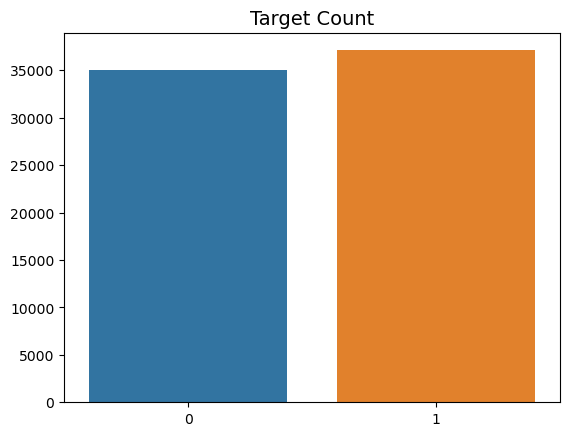

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

label_count = news_data.label.value_counts()

sns.barplot(x=label_count.index, y=label_count.values)  # Use keyword arguments
plt.title('Target Count', fontsize=14)
plt.show()

In [11]:
port = PorterStemmer()

def stemming(text):
    stem_text = re.sub('[^a-zA-Z]', ' ', text)
    stem_text = stem_text.lower()
    stem_text = stem_text.split()
    
    stem_text = [port.stem(word) for word in stem_text if not word in stopwords.words('english')]
    stem_text = ' '.join(stem_text)
    
    return stem_text

In [12]:
def refinement_tfidf(text): # TF-IDF
    ex = text.split('.')
    ex = pd.DataFrame(ex)[0].apply(stemming)
    
    if ex[0] == '':
        return text
    
    vectorizer = TfidfVectorizer()
    try:
        vectorizer.fit(ex)
        features = vectorizer.transform(ex)
    except:
        return text
    
    feature_names = np.array(vectorizer.get_feature_names_out())
    feature_count = features.toarray().mean(axis=0)
    
    refined_text = ' '.join(feature_names[feature_count > 0.05]) # setting the importance weights according to TF-IDF
    
    return refined_text

In [13]:
t0 = time.time()
news_data['refined_tfidf'] = news_data['text'].apply(refinement_tfidf)
print(time.time() - t0)

219865.79365181923


In [14]:
news_data.head()

,Unnamed: 0,title,text,label,refined_tfidf
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,said
1,1,,Did they post their votes for Hillary already?,1,alreadi hillari post vote
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,aka chang constitut creat demonstr eric exerci...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,jindal
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,design dub km mile missil rs sarmat satan weapon


In [15]:
labels = news_data['label'].values
texts = (news_data['title'] + ' ' + news_data['refined_tfidf']).values

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [17]:
idx = np.random.choice(range(len(texts)))
print(texts[idx])
# Tokenized
print(tokenizer.tokenize(texts[idx]))
# Token to Integral
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[idx])))

How they could steal the election from Trump even if he is announced the winner next Tuesday elect elector trump vote would
['how', 'they', 'could', 'steal', 'the', 'election', 'from', 'trump', 'even', 'if', 'he', 'is', 'announced', 'the', 'winner', 'next', 'tuesday', 'elect', 'elector', 'trump', 'vote', 'would']
[2129, 2027, 2071, 8954, 1996, 2602, 2013, 8398, 2130, 2065, 2002, 2003, 2623, 1996, 3453, 2279, 9857, 11322, 20374, 8398, 3789, 2052]


In [18]:
max_len = 0
id_len = []
for text in texts:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    if len(input_ids) > 200:
        continue
    id_len.append(len(input_ids))
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (945 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  197


<Axes: >

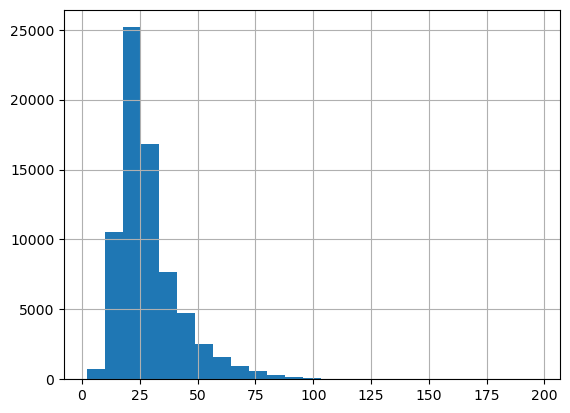

In [19]:
pd.Series(id_len).hist(bins=25)

In [20]:
def tokenize_map(sentences, labels=None):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=128,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True
        )
        input_ids.append(encoded_dict["input_ids"])
        attention_masks.append(encoded_dict["attention_mask"])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    if labels is not None:  # Proper check for None
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [21]:
input_ids, attention_masks, labels = tokenize_map(texts, labels)

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
len(train_dataset.indices), len(val_dataset.indices)

C:\Users\DELL\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2690: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


(57707, 14427)

In [22]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=num_workers)

val_loader = DataLoader(
                dataset=val_dataset,
                batch_size=1,
                shuffle=False)

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [24]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=6e-6,
                              eps=1e-8)

In [25]:
num_epochs = 6 #10
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [26]:
import torch

# Limit dataset size (e.g., use only 50% of the data)
subset_size = int(0.5 * len(train_dataset))  # Adjust fraction as needed -- 0.9
train_dataset = torch.utils.data.Subset(train_dataset, range(subset_size))

# Create DataLoader again with the new subset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
model.train()
total_step = len(train_loader)

for epoch in range(num_epochs):
    total_loss = 0

    for i, (ids, masks, labels) in enumerate(train_loader, start=1):
        ids, masks, labels = ids.to(device), masks.to(device), labels.to(device)

        outputs = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)
        loss = outputs[0]  # Extract loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Print progress every 100 batches
        if i % 100 == 0: # 100
            print(f'{batch_size * i} / {subset_size}')

    avg_loss = total_loss / total_step   
    print(f'Epoch: {epoch+1}, Loss: {avg_loss:.4f}')

# Save model efficiently
import os
import torch

# Ensure the directory exists
save_path = 'nets/BERT.ckpt'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save model
torch.save(model.state_dict(), save_path)
print(f"Model saved successfully at {save_path}")

3200 / 28853
6400 / 28853
9600 / 28853
12800 / 28853
16000 / 28853
19200 / 28853
22400 / 28853
25600 / 28853
28800 / 28853
Epoch: 1, Loss: 0.2683
3200 / 28853
6400 / 28853
9600 / 28853
12800 / 28853
16000 / 28853
19200 / 28853
22400 / 28853
25600 / 28853
28800 / 28853
Epoch: 2, Loss: 0.1483
3200 / 28853
6400 / 28853
9600 / 28853
12800 / 28853
16000 / 28853
19200 / 28853
22400 / 28853
25600 / 28853
28800 / 28853
Epoch: 3, Loss: 0.1029
3200 / 28853
6400 / 28853
9600 / 28853
12800 / 28853
16000 / 28853
19200 / 28853
22400 / 28853
25600 / 28853
28800 / 28853
Epoch: 4, Loss: 0.0722
3200 / 28853
6400 / 28853
9600 / 28853
12800 / 28853
16000 / 28853
19200 / 28853
22400 / 28853
25600 / 28853
28800 / 28853
Epoch: 5, Loss: 0.0500
3200 / 28853
6400 / 28853
9600 / 28853
12800 / 28853
16000 / 28853
19200 / 28853
22400 / 28853
25600 / 28853
28800 / 28853
Epoch: 6, Loss: 0.0366
Model saved successfully at nets/BERT.ckpt


In [27]:
model.eval()
model.load_state_dict(torch.load('nets/BERT.ckpt', map_location=device))

<All keys matched successfully>

In [28]:
import torch

model.eval()  # Set model to evaluation mode
score = 0

with torch.no_grad():  # Disable gradient tracking for efficiency
    for ids, masks, labels in val_loader:
        ids, masks, labels = ids.to(device), masks.to(device), labels.to(device)

        outputs = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)
        logits = outputs[1]  # Extract logits

        preds = torch.argmax(logits, dim=1)  # Get batch predictions
        score += (preds == labels).sum().item()  # Compare entire batch at once

avg = score / len(val_dataset)
print(f'Accuracy: {avg:.4f}\n')

Accuracy: 0.9418



In [29]:
for i in range(5):
    idx = np.random.choice(range(len(news_data)))

    print('\033[1m'+news_data['title'][idx]+'\n')
    print('\033[0m'+news_data['text'][idx])

    label = news_data['label'][idx]
    text = news_data['title'][idx] + ' ' + news_data['refined_tfidf'][idx]

    input_id, attention_mask = tokenize_map([text])

    g_label = model(input_id.to(device), token_type_ids=None, attention_mask=attention_mask.to(device))[0]
    pred = torch.max(g_label, 1)[1][0].item()

    print('\n')
    print('Predict: {}'.format(class_names[pred]))
    print('GT: {}'.format(class_names[label]))
    print('---------------------------------------------------------------------------------------------\n')

OnPolitics | 's politics blog

What you need to know about the election recounts

Green Party presidential candidate Jill Stein intends to seek recounts in Michigan, Pennsylvania and Wisconsin.


Predict: fake
GT: fake
---------------------------------------------------------------------------------------------

First Iraqi Troops Enter Mosul, But Fighting Remains Largely in Suburbs

Military: Goal Is to 'Liberate' Eastern Bank of Tigris River by Jason Ditz, October 31, 2016 Share This 
Iraq’s invasion of Mosul has entered its third week with a noteworthy first, as the first Iraqi special forces entered the city itself in the area around Karama District, in the far east. There was fighting reported both within the district and in surrounding suburbs. 
Indications are that the vast majority of the fighting in the area remains in the suburbs, with only a small incursion into the city itself. Still, Iraqi military officials say their goal is to take the whole eastern bank of the Tigris Ri